# Tools for modern macroeconometrics
## Seminar 3b
## Example 2.2: Fitting deterministic trends to UK output
### Mills -- Modelling Trends and Cycles in Economic Time Series 
#### Chapter 2. page 19

In [2]:
#install.packages("OECD")
library(OECD)
library(magrittr)
library(tidyverse)
library(repr)
library(nlme)
library(ggplot2)
#install.packages("tidyverse")

## Importing the Data 

In [3]:
input=get_dataset("QNA", filter=list("GBR", "B1_GA", "LNBQRSA", "Q"),  start_time = 1995, end_time = 2019)
#QNA - Quarterly National Accounts
#GBR - Great Britain 
# B1_GA: Gross domestic product (output approach)
input %<>% mutate(timeperiod=seq_len(nrow(input)))
input$lngdp = log(as.numeric(input$ObsValue))
input %>% head

FREQUENCY,LOCATION,MEASURE,ObsValue,POWERCODE,REFERENCEPERIOD,SUBJECT,TIME_FORMAT,Time,UNIT,timeperiod,lngdp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
Q,GBR,LNBQRSA,342962,6,2019,B1_GA,P3M,1995-Q1,GBP,1,12.74537
Q,GBR,LNBQRSA,343589,6,2019,B1_GA,P3M,1995-Q2,GBP,2,12.74720
Q,GBR,LNBQRSA,347031,6,2019,B1_GA,P3M,1995-Q3,GBP,3,12.75717
Q,GBR,LNBQRSA,347651,6,2019,B1_GA,P3M,1995-Q4,GBP,4,12.75895
Q,GBR,LNBQRSA,349056,6,2019,B1_GA,P3M,1996-Q1,GBP,5,12.76299
Q,GBR,LNBQRSA,349195,6,2019,B1_GA,P3M,1996-Q2,GBP,6,12.76339


In [4]:
options(repr.plot.width = 10, repr.plot.height = 4)

## GLS trend estimation - With Global Linear Trend 

Figure 1 plots the logarithms of annual UK output (Log GDP) from 1995 to 2019, Q2, upon which is superimposed the fitted linear trend ${\hat \mu}_{lin, t} = 11.83 + 0.005114t$, estimated by feasible GLS using a second-order autoregressive error for $\epsilon_t$. It is clear that this linear trend gives a poor representation of the trend in output, for there are long periods in which the fitted trend is either consistently above output. 

In [5]:
fgls <- gls(lngdp ~ timeperiod, correlation=corARMA(p=1, q=0), data=input)
#fgls <- gls(lngdp ~ timeperiod, data=subinput)
summary(fgls)

Generalized least squares fit by REML
  Model: lngdp ~ timeperiod 
  Data: input 
       AIC       BIC  logLik
  -720.122 -709.7821 364.061

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9999998 

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 12.740398  8.581100 1.484705  0.1408
timeperiod   0.004977  0.000579 8.601122  0.0000

 Correlation: 
           (Intr)
timeperiod -0.003

Standardized residuals:
          Min            Q1           Med            Q3           Max 
-0.0014823546  0.0004095811  0.0012918512  0.0076555312  0.0108639064 

Residual standard error: 8.581098 
Degrees of freedom: 100 total; 98 residual

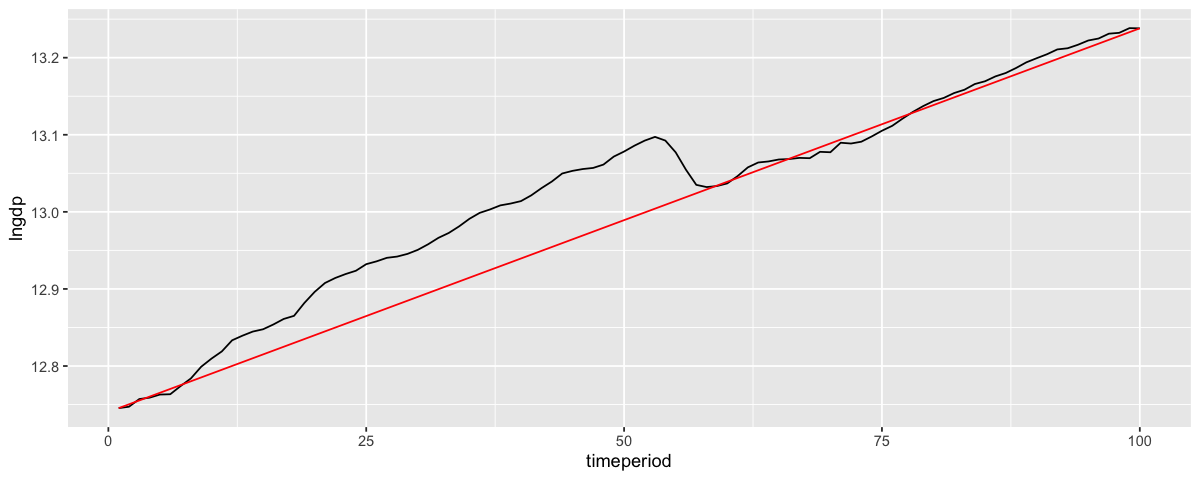

In [6]:
ggplot(data=input, mapping = aes(x=timeperiod, y=lngdp)) +
                                                                                geom_line() +
                                                                                geom_line(aes(y=fgls$fitted), col="red")

## GLS trend estimation -  - Separate Trend

Figure 2 superimposes on output separate trends with a break at 2008-Q3, i.e., in the notation of (2.11), These were obtained by estimating (2.11) by feasible GLS, which produced the fitted trend (with standard errors in parentheses and  $d_{2t}$ taking the value 0 from 1995 to 2008 and 1 from 2008 to 2019):

${\hat \mu}_{lin, t} = 11.59 + 0.0.006585t + 0.558787 d_{2t}    - 0.002719 td_{2t}$ 

          (1.43)       (0.0007)              ( 0.23)                    (0.001)   

 (2.11) 
 \begin{equation}
 y_t = \alpha_1 + \beta_1 t + \sum_{i=2}^{m} \alpha_i d_{it}  + \sum_{i=2}^{m}  \delta_i t d_{it} + \epsilon_t
 \end{equation}

In [7]:
#210  2007-Q2
#211  2007-Q3
#212  2007-Q4
#213  2008-Q1
#214  2008-Q2
#215  2008-Q3
#216  2008-Q4

cut = 55  

input$T1 <- ifelse(input$timeperiod > cut, 1, 0)


subinput <- subset(input, input$Time >= "1995-Q1")



Generalized least squares fit by REML
  Model: lngdp ~ timeperiod + T1 + timeperiod * T1 
  Data: subinput 
        AIC       BIC   logLik
  -725.6752 -710.2891 368.8376

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9999934 

Coefficients:
                  Value Std.Error   t-value p-value
(Intercept)   12.739232 1.3756136  9.260763  0.0000
timeperiod     0.006145 0.0006782  9.061383  0.0000
T1             0.081895 0.0564539  1.450652  0.1501
timeperiod:T1 -0.001976 0.0010122 -1.952005  0.0539

 Correlation: 
              (Intr) timprd T1    
timeperiod    -0.014              
T1             0.000  0.661       
timeperiod:T1  0.000 -0.670 -0.996

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-0.025940635 -0.007993627  0.003024690  0.022240906  0.029165204 

Residual standard error: 1.375604 
Degrees of freedom: 100 total; 96 residual

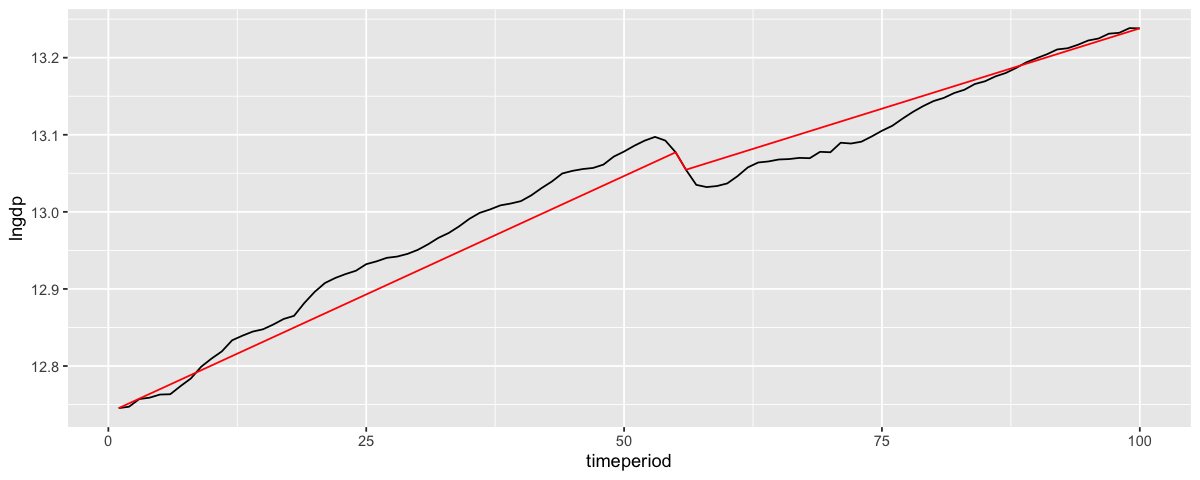

In [8]:
fglsT <- gls(lngdp ~ timeperiod + T1 + timeperiod*T1, correlation=corARMA(p=1, q=0), data=subinput)
summary(fglsT)

ggplot(data=subinput,mapping = aes(x=timeperiod, y=lngdp))+
                                                                                geom_line()+
                                                                                geom_line(aes(y=fglsT$fitted), col="red")

## GLS trend estimation - Segmented Trend

A closer examination of the data shows that there is not a ‘clean’  break in the series at 2008. Rather, output declines rapidly between 2008 and 2009 before returning to a new trend path. We thus also fitted a segmented linear trend of the form (2.12) with $T_1 = 2008$ and $T_2 = 2009$:

${\hat \mu}_{lin, t} = 7.6 +  0.025t -0.020 \phi_{1t}   -0.01766  \phi_{2t}$ 

(2.12)  

\begin{equation}
 y_t = \alpha_1 + \beta_1 t +  \sum_{i=2}^{m}  \delta_i \phi_{it} + \epsilon_t
\end{equation}

where:\\ 

(2.13) 

\begin{equation}
\phi_{it} = d_{it}(t - T_{i-1}) =  \left\{ \begin{array}{rcl} t - T_{i-1},  & t > T_{i-1} \\ 0, & otherwise 
\end{array}\right.
\end{equation}





Generalized least squares fit by REML
  Model: lngdp ~ timeperiod + phi_1 + phi_2 
  Data: subinput 
        AIC       BIC   logLik
  -771.1353 -755.7492 391.5677

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9936989 

Coefficients:
                Value  Std.Error   t-value p-value
(Intercept) 11.700008 0.11212158 104.35109       0
timeperiod   0.024695 0.00191340  12.90638       0
phi_1       -0.019796 0.00182459 -10.84977       0
phi_2       -0.017927 0.00184404  -9.72154       0

 Correlation: 
           (Intr) timprd phi_1 
timeperiod -0.949              
phi_1       0.870 -0.956       
phi_2       0.950 -0.965  0.905

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-0.48958372 -0.04827572  0.12360870  0.25764780  0.74323212 

Residual standard error: 0.0347113 
Degrees of freedom: 100 total; 96 residual

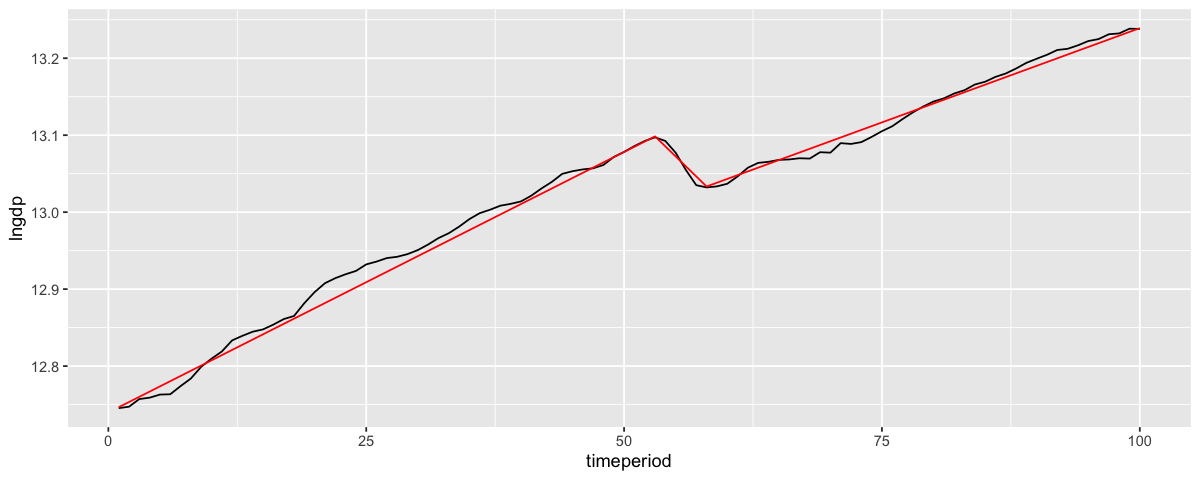

In [9]:
start = 53    #2008-Q1
end = 58     #2009-Q2

input$T_start <- ifelse(input$timeperiod > start, start, 0) #Boom
input$T_end <-  ifelse(input$timeperiod > end, 0, end)   #Bust

input$d_1     <-  ifelse(input$timeperiod > start, 1, 0)      #Boom
input$d_2     <-  ifelse(input$timeperiod > end, 0, 1)       #Bust

input$phi_1 = input$d_1 *(input$timeperiod - input$T_start)
input$phi_2 = input$d_2 *(input$timeperiod - input$T_end)
subinput <- subset(input, input$Time >= "1995-Q1")

fglsT <- gls(lngdp ~ timeperiod + phi_1 + phi_2, correlation=corARMA(p=1, q=0), data=subinput)
summary(fglsT)

ggplot(data=subinput,mapping = aes(x=timeperiod, y=lngdp))+
  geom_line()+
  geom_line(aes(y=fglsT$fitted), col="red")
